## Необходимые библиотеки

In [1]:
!pip install momentumnet
!pip install memory-profiler
!pip install transformers --quiet
!pip install timm
!pip install mlp-mixer-pytorch

  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-py3-none-any.whl size=30190 sha256=66df9d59f0c0f575a900759db7a85f9a49417c9406778e1bdd58fac7d8cd275a
  Stored in directory: /root/.cache/pip/wheels/56/19/d5/8cad06661aec65a04a0d6785b1a5ad035cb645b1772a4a0882
Successfully built memory-profiler
     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 43.0 MB/s 
     |████████████████████████████████| 3.3 MB 20.8 MB/s 
     |████████████████████████████████| 895 kB 40.9 MB/s 
     |████████████████████████████████| 59 kB 6.4 MB/s 
     |████████████████████████████████| 376 kB 5.4 MB/s 


In [2]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

import torchvision.transforms as T
import torchvision.datasets as D
import torchvision
import torch
import timm
from vit_pytorch import ViT
from mlp_mixer_pytorch import MLPMixer
import momentumnet
import random
from momentumnet import transform_to_momentumnet, MomentumNet
from tqdm import tqdm

import numpy as np
from memory_profiler import memory_usage
import torch.nn as nn
from matplotlib import pyplot as plt

import os

In [3]:
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

## Тест потребления памяти

для честности теста нужно каждый раз перезапускать среду выполнения





### Vision Transformer

In [ ]:
CRITERION = torch.nn.CrossEntropyLoss().to('cuda')
BATCH_SIZE = 8

def loss_func(model):
    # for INPUT, TARGET in train_loader:
        IN = torch.rand(BATCH_SIZE, 3, 224, 224)
        #input = fe(images=IN, return_tensors="pt", do_resize=False)
        target = torch.zeros(BATCH_SIZE).long()
        out = model(IN)
        loss = CRITERION(out, target)
        return loss.backward()

In [ ]:
def run_model(image_size=224, patch_size=16, num_classes=1000, depth=12, heads=12, use_momentum=False, gamma=0.9):
    
    v = ViT(
        image_size = image_size,
        patch_size = patch_size,
        num_classes = num_classes,
        dim = 768,
        depth = depth,
        heads = heads,
        mlp_dim = 3072,
        dropout = 0.1,
        emb_dropout = 0.1
    )
    if use_momentum == False:
        return v
    
    momentum_v = transform_to_momentumnet(v, sub_layers=["transformer.layers." + str(i) for i in range(depth)], gamma=gamma)
    return momentum_v


model = run_model(depth=12, use_momentum=True)

In [ ]:
%%time

np.max(memory_usage((loss_func, [model], )))

CPU times: user 19.1 s, sys: 867 ms, total: 20 s
Wall time: 19.9 s


3148.4921875

In [ ]:
vit_batches = [8, 16, 32, 48]
vit_res_m = [3149, 4401, 6807, 9385]
vit_res = [3477, 5071, 8288, 11490]
vit_time_m = [20, 40, 80, 121]
vit_time = [15, 30, 59, 90]

In [ ]:
ds = [4, 8, 12, 16]
vit_res_32 = [3884, 6079, 8256, 10537]
vit_res_32_m = [3688, 5358, 6973, 8612] 

### MLP-Mixer

In [ ]:
CRITERION = torch.nn.CrossEntropyLoss().to('cuda')
BATCH_SIZE = 32

def loss_func(model):
    # for INPUT, TARGET in train_loader:
        IN = torch.rand(BATCH_SIZE, 3, 224, 224)
        #input = fe(images=IN, return_tensors="pt", do_resize=False)
        target = torch.zeros(BATCH_SIZE).long()
        out = model(IN)
        loss = CRITERION(out, target)
        return loss.backward()

In [ ]:
def run_model(image_size=224, patch_size=16, num_classes=1000, depth=12, dim=768, use_momentum=False, gamma=0.9):

    model = MLPMixer(
        image_size = image_size,
        channels = 3,
        patch_size = patch_size,
        dim = dim,
        depth = depth,
        num_classes = num_classes
    )
    if use_momentum == False:
        return model
    
    momentum_m = transform_to_momentumnet(model, sub_layers=[str(i + 2) for i in range(depth)], gamma=gamma)
    return momentum_m


model = run_model(depth=16, use_momentum=True)

In [ ]:
%%time

np.max(memory_usage((loss_func, [model], )))

CPU times: user 1min 28s, sys: 2.77 s, total: 1min 31s
Wall time: 1min 30s


6794.59765625

In [ ]:
mlp_batches = [8, 16, 32, 48, 64]
mlp_res_m = [2711, 3648, 5530, 7404, 9216]
mlp_res = [2914, 4053, 6365, 8642, 10960]
mlp_time_m = [17, 34, 68, 102, 135]
mlp_time = [12, 24, 48, 71, 95]

In [ ]:
ds = [4, 8, 12, 16]
mlp_res_32 = [3254, 4821, 6365, 7909]
mlp_res_32_m = [3139, 4392, 5530, 6795] 

### Graphs

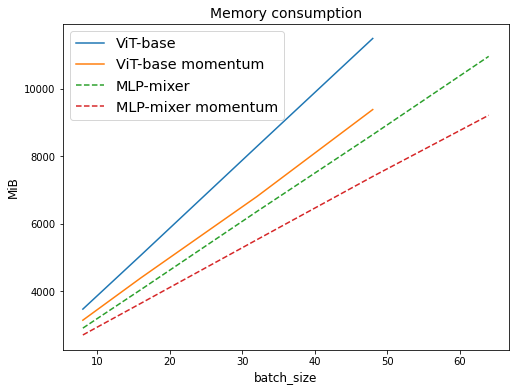

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(vit_batches, vit_res, label='ViT-base')
plt.plot(vit_batches, vit_res_m, label='ViT-base momentum')
plt.plot(mlp_batches, mlp_res, label='MLP-mixer', linestyle='dashed')
plt.plot(mlp_batches, mlp_res_m, label='MLP-mixer momentum', linestyle='dashed')
plt.title('Memory consumption', fontsize=14)
plt.xlabel('batch_size', fontsize=12)
plt.ylabel('MiB', fontsize=12)
plt.legend(fontsize='x-large')
plt.savefig('1')
plt.show()

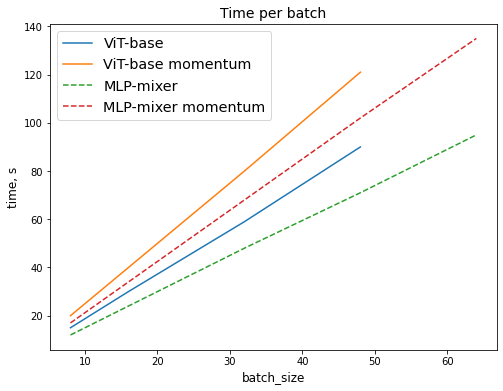

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(vit_batches, vit_time, label='ViT-base')
plt.plot(vit_batches, vit_time_m, label='ViT-base momentum')
plt.plot(mlp_batches, mlp_time, label='MLP-mixer', linestyle='dashed')
plt.plot(mlp_batches, mlp_time_m, label='MLP-mixer momentum', linestyle='dashed')
plt.title('Time per batch', fontsize=14)
plt.xlabel('batch_size', fontsize=12)
plt.ylabel('time, s', fontsize=12)
plt.legend(fontsize='x-large')
plt.savefig('2')
plt.show()

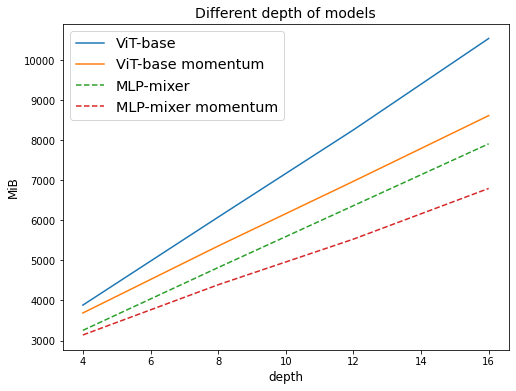

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(ds, vit_res_32, label='ViT-base')
plt.plot(ds, vit_res_32_m, label='ViT-base momentum')
plt.plot(ds, mlp_res_32, label='MLP-mixer', linestyle='dashed')
plt.plot(ds, mlp_res_32_m, label='MLP-mixer momentum', linestyle='dashed')
plt.title('Different depth of models', fontsize=14)
plt.xlabel('depth', fontsize=12)
plt.ylabel('MiB', fontsize=12)
plt.legend(fontsize='x-large')
plt.savefig('3')
plt.show()

## Fine-tuning results


In [4]:
!wget --quiet --show-progress "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
!unzip -q ./hymenoptera_data.zip

hymenoptera_data.zi 100%[===================>]  45.10M   133MB/s    in 0.3s    


In [5]:
data_transforms = {
    'train': T.Compose([
        T.RandomResizedCrop(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: D.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

CRITERION = torch.nn.CrossEntropyLoss().to('cuda')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
class_names

['ants', 'bees']

In [8]:
def train(model, optimizer, num_epoch):
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []

    for epoch in range(1, num_epoch + 1):
        cur_loss = 0
        cur_iter = 0

        preds = []
        targets = []
        
        model.train()
        for idx, (x, y) in enumerate(tqdm(dataloaders['train'], leave=True, position=0)):
            
            optimizer.zero_grad()
            
            x = x.cuda()
            y = y.cuda()
            
            logits = model(x)
            loss = CRITERION(logits, y)

            with torch.no_grad():
                preds.append(torch.max(logits, dim=1)[1].cpu())
                targets.append(y.cpu())
            
            loss.backward()
            optimizer.step()

            cur_loss += loss.item()
            cur_iter += 1
            
            # progress_bar.set_postfix({
            #     'Epoch': epoch,
            #     'Loss': cur_loss / cur_iter
            # })

        preds = torch.cat(preds).numpy()
        targets = torch.cat(targets).numpy()   
        
        val_loss, val_acc = test(model)
        test_losses.append(val_loss)
        test_acc.append(val_acc)

        train_losses.append(cur_loss / cur_iter)
        train_acc.append((preds == targets).mean())
     
        print(f'Epoch {epoch} ended, Train Loss: {cur_loss / cur_iter}, Val Loss: {val_loss}')
        print(f'Train Accuracy: {(preds == targets).mean()} Val Accuracy: {val_acc}')
    
    return train_losses, test_losses, train_acc, test_acc


@torch.no_grad()
def test(model):
    model.eval()

    preds = []
    targets = []
    cur_loss = 0
    cur_iter = 0


    for x, y in dataloaders['val']:
        x = x.to('cuda')
        y = y.to('cuda')

        logits = model(x)

        loss = CRITERION(logits, y)

        cur_loss += loss.item()
        cur_iter += 1
                
        preds.append(torch.max(logits, dim=1)[1].cpu())
        targets.append(y.cpu())
        
    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()

    return cur_loss / cur_iter, (preds == targets).mean()

In [26]:
N_CLASSES = 2
N_EPOCHS = 60


model = torchvision.models.resnet18(pretrained=True).to('cuda')
model.fc = nn.Linear(model.fc.in_features, N_CLASSES).to('cuda')


train_losses, test_losses, train_acc, test_acc = train(model, torch.optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=1e-4), N_EPOCHS)

  0%|          | 0/61 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [00:04<00:00, 12.48it/s]


Epoch 1 ended, Train Loss: 0.5281975774979982, Val Loss: 0.31790952938489425
Train Accuracy: 0.75 Val Accuracy: 0.8366013071895425


100%|██████████| 61/61 [00:04<00:00, 12.85it/s]


Epoch 2 ended, Train Loss: 0.49259617179632187, Val Loss: 0.46198595131341463
Train Accuracy: 0.7704918032786885 Val Accuracy: 0.803921568627451


100%|██████████| 61/61 [00:04<00:00, 12.92it/s]


Epoch 3 ended, Train Loss: 0.4045074195524708, Val Loss: 0.5222941015455991
Train Accuracy: 0.8114754098360656 Val Accuracy: 0.8366013071895425


100%|██████████| 61/61 [00:04<00:00, 12.81it/s]


Epoch 4 ended, Train Loss: 0.38221652935579664, Val Loss: 0.5544076157339777
Train Accuracy: 0.819672131147541 Val Accuracy: 0.7908496732026143


100%|██████████| 61/61 [00:04<00:00, 12.94it/s]


Epoch 5 ended, Train Loss: 0.31959105084543343, Val Loss: 0.33510760759982544
Train Accuracy: 0.8647540983606558 Val Accuracy: 0.9150326797385621


100%|██████████| 61/61 [00:04<00:00, 12.83it/s]


Epoch 6 ended, Train Loss: 0.3664342202856892, Val Loss: 0.4230596163692192
Train Accuracy: 0.8442622950819673 Val Accuracy: 0.8888888888888888


100%|██████████| 61/61 [00:04<00:00, 12.88it/s]


Epoch 7 ended, Train Loss: 0.3535117862257557, Val Loss: 0.4355703328545086
Train Accuracy: 0.8688524590163934 Val Accuracy: 0.8300653594771242


100%|██████████| 61/61 [00:04<00:00, 12.87it/s]


Epoch 8 ended, Train Loss: 0.34609518780327236, Val Loss: 0.4008944832782548
Train Accuracy: 0.8565573770491803 Val Accuracy: 0.869281045751634


100%|██████████| 61/61 [00:04<00:00, 12.80it/s]


Epoch 9 ended, Train Loss: 0.30482294439475555, Val Loss: 0.3640456900048332
Train Accuracy: 0.8811475409836066 Val Accuracy: 0.8888888888888888


100%|██████████| 61/61 [00:04<00:00, 12.90it/s]


Epoch 10 ended, Train Loss: 0.3060508987973215, Val Loss: 0.2879532313762376
Train Accuracy: 0.8811475409836066 Val Accuracy: 0.9019607843137255


100%|██████████| 61/61 [00:04<00:00, 12.91it/s]


Epoch 11 ended, Train Loss: 0.3428881581200928, Val Loss: 0.25313487376731175
Train Accuracy: 0.8401639344262295 Val Accuracy: 0.9084967320261438


100%|██████████| 61/61 [00:04<00:00, 12.92it/s]


Epoch 12 ended, Train Loss: 0.27408002303210927, Val Loss: 0.3420662238286474
Train Accuracy: 0.9098360655737705 Val Accuracy: 0.8627450980392157


100%|██████████| 61/61 [00:04<00:00, 12.96it/s]


Epoch 13 ended, Train Loss: 0.34773982616263577, Val Loss: 0.2958850644958707
Train Accuracy: 0.8647540983606558 Val Accuracy: 0.8758169934640523


100%|██████████| 61/61 [00:04<00:00, 12.82it/s]


Epoch 14 ended, Train Loss: 0.40245597791232046, Val Loss: 0.29760372297217447
Train Accuracy: 0.8319672131147541 Val Accuracy: 0.9019607843137255


100%|██████████| 61/61 [00:04<00:00, 12.91it/s]


Epoch 15 ended, Train Loss: 0.30441184900701046, Val Loss: 0.2356703714109384
Train Accuracy: 0.8647540983606558 Val Accuracy: 0.9019607843137255


100%|██████████| 61/61 [00:04<00:00, 12.76it/s]


Epoch 16 ended, Train Loss: 0.2997051430255419, Val Loss: 0.26031674478107536
Train Accuracy: 0.8729508196721312 Val Accuracy: 0.9084967320261438


100%|██████████| 61/61 [00:04<00:00, 12.83it/s]


Epoch 17 ended, Train Loss: 0.2913985324138012, Val Loss: 0.22444208008117783
Train Accuracy: 0.8647540983606558 Val Accuracy: 0.9019607843137255


100%|██████████| 61/61 [00:04<00:00, 12.96it/s]


Epoch 18 ended, Train Loss: 0.30260850918158644, Val Loss: 0.36791124170980394
Train Accuracy: 0.8647540983606558 Val Accuracy: 0.8562091503267973


100%|██████████| 61/61 [00:04<00:00, 12.93it/s]


Epoch 19 ended, Train Loss: 0.28720463760441445, Val Loss: 0.27770924128783053
Train Accuracy: 0.8811475409836066 Val Accuracy: 0.8954248366013072


100%|██████████| 61/61 [00:04<00:00, 12.70it/s]


Epoch 20 ended, Train Loss: 0.2419554959051311, Val Loss: 0.469388065716395
Train Accuracy: 0.9139344262295082 Val Accuracy: 0.8562091503267973


100%|██████████| 61/61 [00:04<00:00, 12.71it/s]


Epoch 21 ended, Train Loss: 0.3035975642899265, Val Loss: 0.23675475501192686
Train Accuracy: 0.8852459016393442 Val Accuracy: 0.8888888888888888


100%|██████████| 61/61 [00:04<00:00, 12.85it/s]


Epoch 22 ended, Train Loss: 0.27345242560459454, Val Loss: 0.2654089705430147
Train Accuracy: 0.8647540983606558 Val Accuracy: 0.9150326797385621


100%|██████████| 61/61 [00:04<00:00, 12.92it/s]


Epoch 23 ended, Train Loss: 0.18233217338680244, Val Loss: 0.3410566772501438
Train Accuracy: 0.9180327868852459 Val Accuracy: 0.8954248366013072


100%|██████████| 61/61 [00:04<00:00, 12.85it/s]


Epoch 24 ended, Train Loss: 0.32279980573497835, Val Loss: 0.37870049867062616
Train Accuracy: 0.8647540983606558 Val Accuracy: 0.8888888888888888


100%|██████████| 61/61 [00:04<00:00, 12.92it/s]


Epoch 25 ended, Train Loss: 0.26872266635115516, Val Loss: 0.3656546463473485
Train Accuracy: 0.8934426229508197 Val Accuracy: 0.9084967320261438


100%|██████████| 61/61 [00:04<00:00, 12.93it/s]


Epoch 26 ended, Train Loss: 0.2582529856991328, Val Loss: 0.31900976876465553
Train Accuracy: 0.8975409836065574 Val Accuracy: 0.9150326797385621


100%|██████████| 61/61 [00:04<00:00, 12.92it/s]


Epoch 27 ended, Train Loss: 0.2759315485714889, Val Loss: 0.2988633602165068
Train Accuracy: 0.8811475409836066 Val Accuracy: 0.9084967320261438


100%|██████████| 61/61 [00:04<00:00, 12.90it/s]


Epoch 28 ended, Train Loss: 0.17165799142762286, Val Loss: 0.4238315963675865
Train Accuracy: 0.9221311475409836 Val Accuracy: 0.8627450980392157


100%|██████████| 61/61 [00:04<00:00, 12.83it/s]


Epoch 29 ended, Train Loss: 0.23312721576266845, Val Loss: 0.3284470565820065
Train Accuracy: 0.9221311475409836 Val Accuracy: 0.8823529411764706


100%|██████████| 61/61 [00:04<00:00, 12.89it/s]


Epoch 30 ended, Train Loss: 0.16858451313446046, Val Loss: 0.3151092849050959
Train Accuracy: 0.9385245901639344 Val Accuracy: 0.8888888888888888


100%|██████████| 61/61 [00:04<00:00, 12.71it/s]


Epoch 31 ended, Train Loss: 0.26696660928046484, Val Loss: 0.32921817826811606
Train Accuracy: 0.8770491803278688 Val Accuracy: 0.8823529411764706


100%|██████████| 61/61 [00:04<00:00, 12.91it/s]


Epoch 32 ended, Train Loss: 0.2803726350262639, Val Loss: 0.29035361349964756
Train Accuracy: 0.8729508196721312 Val Accuracy: 0.8758169934640523


100%|██████████| 61/61 [00:04<00:00, 12.93it/s]


Epoch 33 ended, Train Loss: 0.22210317466896576, Val Loss: 0.34972834651424095
Train Accuracy: 0.889344262295082 Val Accuracy: 0.8888888888888888


100%|██████████| 61/61 [00:04<00:00, 12.92it/s]


Epoch 34 ended, Train Loss: 0.23407691639283154, Val Loss: 0.27355398046664703
Train Accuracy: 0.9139344262295082 Val Accuracy: 0.9150326797385621


100%|██████████| 61/61 [00:04<00:00, 12.80it/s]


Epoch 35 ended, Train Loss: 0.20278828259038387, Val Loss: 0.22667118245758153
Train Accuracy: 0.9057377049180327 Val Accuracy: 0.934640522875817


100%|██████████| 61/61 [00:04<00:00, 12.84it/s]


Epoch 36 ended, Train Loss: 0.2469550605451108, Val Loss: 0.30246818592795766
Train Accuracy: 0.8975409836065574 Val Accuracy: 0.934640522875817


100%|██████████| 61/61 [00:04<00:00, 12.69it/s]


Epoch 37 ended, Train Loss: 0.24033859564510526, Val Loss: 0.30424883443480116
Train Accuracy: 0.9016393442622951 Val Accuracy: 0.8888888888888888


100%|██████████| 61/61 [00:04<00:00, 12.97it/s]


Epoch 38 ended, Train Loss: 0.20830742173568637, Val Loss: 0.3496941107277496
Train Accuracy: 0.9139344262295082 Val Accuracy: 0.8823529411764706


100%|██████████| 61/61 [00:04<00:00, 12.93it/s]


Epoch 39 ended, Train Loss: 0.13769096530760166, Val Loss: 0.284394562498141
Train Accuracy: 0.9467213114754098 Val Accuracy: 0.8954248366013072


100%|██████████| 61/61 [00:04<00:00, 12.90it/s]


Epoch 40 ended, Train Loss: 0.2524137584507832, Val Loss: 0.33344185060988635
Train Accuracy: 0.8811475409836066 Val Accuracy: 0.8888888888888888


100%|██████████| 61/61 [00:04<00:00, 12.82it/s]


Epoch 41 ended, Train Loss: 0.23292972936798803, Val Loss: 0.3055001139903489
Train Accuracy: 0.9016393442622951 Val Accuracy: 0.8888888888888888


100%|██████████| 61/61 [00:04<00:00, 12.75it/s]


Epoch 42 ended, Train Loss: 0.2434957991048816, Val Loss: 0.24267351707702545
Train Accuracy: 0.889344262295082 Val Accuracy: 0.9215686274509803


100%|██████████| 61/61 [00:04<00:00, 12.90it/s]


Epoch 43 ended, Train Loss: 0.20130798142769787, Val Loss: 0.23973849426525143
Train Accuracy: 0.9098360655737705 Val Accuracy: 0.8888888888888888


100%|██████████| 61/61 [00:04<00:00, 12.89it/s]


Epoch 44 ended, Train Loss: 0.1498568714749007, Val Loss: 0.24314853177370074
Train Accuracy: 0.9508196721311475 Val Accuracy: 0.9281045751633987


100%|██████████| 61/61 [00:04<00:00, 12.88it/s]


Epoch 45 ended, Train Loss: 0.19688359588445697, Val Loss: 0.2482653584283514
Train Accuracy: 0.9385245901639344 Val Accuracy: 0.9019607843137255


100%|██████████| 61/61 [00:04<00:00, 12.76it/s]


Epoch 46 ended, Train Loss: 0.2138278323767676, Val Loss: 0.2241752227120555
Train Accuracy: 0.9221311475409836 Val Accuracy: 0.9084967320261438


100%|██████████| 61/61 [00:04<00:00, 12.80it/s]


Epoch 47 ended, Train Loss: 0.2288851312926558, Val Loss: 0.22684783024044755
Train Accuracy: 0.9098360655737705 Val Accuracy: 0.9084967320261438


100%|██████████| 61/61 [00:04<00:00, 12.89it/s]


Epoch 48 ended, Train Loss: 0.22433393756996411, Val Loss: 0.2428960495341856
Train Accuracy: 0.9016393442622951 Val Accuracy: 0.8954248366013072


100%|██████████| 61/61 [00:04<00:00, 12.87it/s]


Epoch 49 ended, Train Loss: 0.16969639766717054, Val Loss: 0.30679946078154713
Train Accuracy: 0.9467213114754098 Val Accuracy: 0.8758169934640523


100%|██████████| 61/61 [00:04<00:00, 12.84it/s]


Epoch 50 ended, Train Loss: 0.1413385741809597, Val Loss: 0.21852639798695841
Train Accuracy: 0.9426229508196722 Val Accuracy: 0.9411764705882353


100%|██████████| 61/61 [00:04<00:00, 12.90it/s]


Epoch 51 ended, Train Loss: 0.16970474476788622, Val Loss: 0.451437186031865
Train Accuracy: 0.930327868852459 Val Accuracy: 0.8627450980392157


100%|██████████| 61/61 [00:04<00:00, 12.96it/s]


Epoch 52 ended, Train Loss: 0.17352044191135124, Val Loss: 0.24351524418363205
Train Accuracy: 0.9385245901639344 Val Accuracy: 0.9019607843137255


100%|██████████| 61/61 [00:04<00:00, 12.95it/s]


Epoch 53 ended, Train Loss: 0.16038046600144418, Val Loss: 0.2919719689525664
Train Accuracy: 0.930327868852459 Val Accuracy: 0.8758169934640523


100%|██████████| 61/61 [00:04<00:00, 12.89it/s]


Epoch 54 ended, Train Loss: 0.13574780416903925, Val Loss: 0.2720592515184902
Train Accuracy: 0.9549180327868853 Val Accuracy: 0.8954248366013072


100%|██████████| 61/61 [00:04<00:00, 12.97it/s]


Epoch 55 ended, Train Loss: 0.19140748982699435, Val Loss: 0.32365384958505344
Train Accuracy: 0.9098360655737705 Val Accuracy: 0.8823529411764706


100%|██████████| 61/61 [00:04<00:00, 12.76it/s]


Epoch 56 ended, Train Loss: 0.1559855626918925, Val Loss: 0.3460950398114689
Train Accuracy: 0.9180327868852459 Val Accuracy: 0.869281045751634


100%|██████████| 61/61 [00:04<00:00, 12.90it/s]


Epoch 57 ended, Train Loss: 0.15065931939886365, Val Loss: 0.27879414074302006
Train Accuracy: 0.9467213114754098 Val Accuracy: 0.9084967320261438


100%|██████████| 61/61 [00:04<00:00, 12.93it/s]


Epoch 58 ended, Train Loss: 0.1261298040760162, Val Loss: 0.27341866594118375
Train Accuracy: 0.9385245901639344 Val Accuracy: 0.9019607843137255


100%|██████████| 61/61 [00:04<00:00, 12.92it/s]


Epoch 59 ended, Train Loss: 0.14207890664883813, Val Loss: 0.28927440407017296
Train Accuracy: 0.9262295081967213 Val Accuracy: 0.9084967320261438


100%|██████████| 61/61 [00:04<00:00, 12.73it/s]


Epoch 60 ended, Train Loss: 0.11995839002183409, Val Loss: 0.24522589553052035
Train Accuracy: 0.9590163934426229 Val Accuracy: 0.9215686274509803


In [27]:
N_CLASSES = 2
N_EPOCHS = 60

model = transform_to_momentumnet(torchvision.models.resnet18(pretrained=True)).to('cuda')
model.fc = nn.Linear(model.fc.in_features, N_CLASSES).to('cuda')


train_losses1, test_losses1, train_acc1, test_acc1 = train(model, torch.optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=1e-4), N_EPOCHS)

  0%|          | 0/61 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 61/61 [00:06<00:00, 10.01it/s]


Epoch 1 ended, Train Loss: 0.604021674296895, Val Loss: 0.43905888459621334
Train Accuracy: 0.6926229508196722 Val Accuracy: 0.7973856209150327


100%|██████████| 61/61 [00:06<00:00, 10.05it/s]


Epoch 2 ended, Train Loss: 0.4996900214035003, Val Loss: 0.6365270424538698
Train Accuracy: 0.7745901639344263 Val Accuracy: 0.6797385620915033


100%|██████████| 61/61 [00:06<00:00, 10.05it/s]


Epoch 3 ended, Train Loss: 0.4928698893941817, Val Loss: 0.3949633836746216
Train Accuracy: 0.7663934426229508 Val Accuracy: 0.8104575163398693


100%|██████████| 61/61 [00:06<00:00,  9.96it/s]


Epoch 4 ended, Train Loss: 0.45618117832746663, Val Loss: 0.37546324534102893
Train Accuracy: 0.8032786885245902 Val Accuracy: 0.8627450980392157


100%|██████████| 61/61 [00:06<00:00, 10.01it/s]


Epoch 5 ended, Train Loss: 0.4037053506882464, Val Loss: 0.4288646083038587
Train Accuracy: 0.8278688524590164 Val Accuracy: 0.803921568627451


100%|██████████| 61/61 [00:06<00:00, 10.02it/s]


Epoch 6 ended, Train Loss: 0.4179123621739325, Val Loss: 0.345910319342063
Train Accuracy: 0.7950819672131147 Val Accuracy: 0.8627450980392157


100%|██████████| 61/61 [00:06<00:00, 10.06it/s]


Epoch 7 ended, Train Loss: 0.36371444507700496, Val Loss: 0.33767892324771637
Train Accuracy: 0.8483606557377049 Val Accuracy: 0.8496732026143791


100%|██████████| 61/61 [00:06<00:00, 10.09it/s]


Epoch 8 ended, Train Loss: 0.3151840230480569, Val Loss: 0.41034144036567366
Train Accuracy: 0.8811475409836066 Val Accuracy: 0.8627450980392157


100%|██████████| 61/61 [00:06<00:00, 10.02it/s]


Epoch 9 ended, Train Loss: 0.42180342898994194, Val Loss: 0.5138762095369972
Train Accuracy: 0.7950819672131147 Val Accuracy: 0.7843137254901961


100%|██████████| 61/61 [00:06<00:00, 10.02it/s]


Epoch 10 ended, Train Loss: 0.3499879309388458, Val Loss: 0.39357275052521473
Train Accuracy: 0.8729508196721312 Val Accuracy: 0.8431372549019608


100%|██████████| 61/61 [00:06<00:00, 10.10it/s]


Epoch 11 ended, Train Loss: 0.33278613305482707, Val Loss: 0.3954939369876415
Train Accuracy: 0.8647540983606558 Val Accuracy: 0.8496732026143791


100%|██████████| 61/61 [00:06<00:00, 10.12it/s]


Epoch 12 ended, Train Loss: 0.31900014264173193, Val Loss: 0.4374114642170566
Train Accuracy: 0.8770491803278688 Val Accuracy: 0.8562091503267973


100%|██████████| 61/61 [00:06<00:00, 10.02it/s]


Epoch 13 ended, Train Loss: 0.3058636260570073, Val Loss: 0.3511039095166593
Train Accuracy: 0.8934426229508197 Val Accuracy: 0.8627450980392157


100%|██████████| 61/61 [00:06<00:00, 10.11it/s]


Epoch 14 ended, Train Loss: 0.34425515351725405, Val Loss: 0.39129190728402674
Train Accuracy: 0.8565573770491803 Val Accuracy: 0.8496732026143791


100%|██████████| 61/61 [00:06<00:00, 10.06it/s]


Epoch 15 ended, Train Loss: 0.3527195613648071, Val Loss: 0.3720326971811935
Train Accuracy: 0.8442622950819673 Val Accuracy: 0.869281045751634


100%|██████████| 61/61 [00:06<00:00,  9.98it/s]


Epoch 16 ended, Train Loss: 0.3053536652052989, Val Loss: 0.4215260828869083
Train Accuracy: 0.8811475409836066 Val Accuracy: 0.8366013071895425


100%|██████████| 61/61 [00:06<00:00, 10.04it/s]


Epoch 17 ended, Train Loss: 0.31496660246467983, Val Loss: 0.4086909053178552
Train Accuracy: 0.8729508196721312 Val Accuracy: 0.8562091503267973


100%|██████████| 61/61 [00:06<00:00, 10.05it/s]


Epoch 18 ended, Train Loss: 0.28991638942331566, Val Loss: 0.3781377377991493
Train Accuracy: 0.8770491803278688 Val Accuracy: 0.8627450980392157


100%|██████████| 61/61 [00:06<00:00,  9.74it/s]


Epoch 19 ended, Train Loss: 0.3286546876073861, Val Loss: 0.271226082665798
Train Accuracy: 0.860655737704918 Val Accuracy: 0.9084967320261438


100%|██████████| 61/61 [00:06<00:00,  9.88it/s]


Epoch 20 ended, Train Loss: 0.2558345290847489, Val Loss: 0.4839763972573938
Train Accuracy: 0.9016393442622951 Val Accuracy: 0.8366013071895425


100%|██████████| 61/61 [00:06<00:00,  9.89it/s]


Epoch 21 ended, Train Loss: 0.20059759218673237, Val Loss: 0.3522393003297158
Train Accuracy: 0.930327868852459 Val Accuracy: 0.8562091503267973


100%|██████████| 61/61 [00:06<00:00,  9.86it/s]


Epoch 22 ended, Train Loss: 0.32336468365593035, Val Loss: 0.5405180240766361
Train Accuracy: 0.8442622950819673 Val Accuracy: 0.7908496732026143


100%|██████████| 61/61 [00:06<00:00,  9.85it/s]


Epoch 23 ended, Train Loss: 0.3364340855327786, Val Loss: 0.4494187726970547
Train Accuracy: 0.8647540983606558 Val Accuracy: 0.8300653594771242


100%|██████████| 61/61 [00:06<00:00,  9.81it/s]


Epoch 24 ended, Train Loss: 0.2564292971472271, Val Loss: 0.5054274669442421
Train Accuracy: 0.9221311475409836 Val Accuracy: 0.7843137254901961


100%|██████████| 61/61 [00:06<00:00,  9.74it/s]


Epoch 25 ended, Train Loss: 0.2704919983984017, Val Loss: 0.34501778088563767
Train Accuracy: 0.9016393442622951 Val Accuracy: 0.8888888888888888


100%|██████████| 61/61 [00:06<00:00,  9.89it/s]


Epoch 26 ended, Train Loss: 0.2805009889187383, Val Loss: 0.42630301056376013
Train Accuracy: 0.8975409836065574 Val Accuracy: 0.8300653594771242


100%|██████████| 61/61 [00:06<00:00,  9.91it/s]


Epoch 27 ended, Train Loss: 0.2513647367719744, Val Loss: 0.551034635458237
Train Accuracy: 0.9221311475409836 Val Accuracy: 0.8431372549019608


100%|██████████| 61/61 [00:06<00:00,  9.83it/s]


Epoch 28 ended, Train Loss: 0.286249306205599, Val Loss: 0.676329326386062
Train Accuracy: 0.8811475409836066 Val Accuracy: 0.7450980392156863


100%|██████████| 61/61 [00:06<00:00,  9.94it/s]


Epoch 29 ended, Train Loss: 0.2494758320514296, Val Loss: 0.34665470694502193
Train Accuracy: 0.9139344262295082 Val Accuracy: 0.8888888888888888


100%|██████████| 61/61 [00:06<00:00,  9.98it/s]


Epoch 30 ended, Train Loss: 0.2962077685982966, Val Loss: 0.547593494077237
Train Accuracy: 0.8770491803278688 Val Accuracy: 0.8431372549019608


100%|██████████| 61/61 [00:06<00:00,  9.96it/s]


Epoch 31 ended, Train Loss: 0.3162131360808357, Val Loss: 0.41530319991020054
Train Accuracy: 0.8852459016393442 Val Accuracy: 0.8431372549019608


100%|██████████| 61/61 [00:06<00:00,  9.91it/s]


Epoch 32 ended, Train Loss: 0.21292965382826132, Val Loss: 0.35769520175302044
Train Accuracy: 0.9139344262295082 Val Accuracy: 0.869281045751634


100%|██████████| 61/61 [00:06<00:00,  9.97it/s]


Epoch 33 ended, Train Loss: 0.2862217743255076, Val Loss: 0.5103978158619541
Train Accuracy: 0.8975409836065574 Val Accuracy: 0.8169934640522876


100%|██████████| 61/61 [00:06<00:00, 10.01it/s]


Epoch 34 ended, Train Loss: 0.26516262936543245, Val Loss: 0.3574422859491255
Train Accuracy: 0.8770491803278688 Val Accuracy: 0.8954248366013072


100%|██████████| 61/61 [00:06<00:00,  9.96it/s]


Epoch 35 ended, Train Loss: 0.25151516246746797, Val Loss: 0.3575968041490668
Train Accuracy: 0.9057377049180327 Val Accuracy: 0.8431372549019608


100%|██████████| 61/61 [00:06<00:00,  9.97it/s]


Epoch 36 ended, Train Loss: 0.27500730746837915, Val Loss: 0.44860599135072565
Train Accuracy: 0.8770491803278688 Val Accuracy: 0.803921568627451


100%|██████████| 61/61 [00:06<00:00,  9.91it/s]


Epoch 37 ended, Train Loss: 0.2368941781279005, Val Loss: 0.32652845666505015
Train Accuracy: 0.9057377049180327 Val Accuracy: 0.869281045751634


100%|██████████| 61/61 [00:06<00:00,  9.99it/s]


Epoch 38 ended, Train Loss: 0.23405547073630037, Val Loss: 0.3851880983162958
Train Accuracy: 0.9139344262295082 Val Accuracy: 0.8235294117647058


100%|██████████| 61/61 [00:06<00:00, 10.01it/s]


Epoch 39 ended, Train Loss: 0.2160026257643934, Val Loss: 0.3522839374267138
Train Accuracy: 0.9139344262295082 Val Accuracy: 0.9084967320261438


100%|██████████| 61/61 [00:06<00:00,  9.98it/s]


Epoch 40 ended, Train Loss: 0.1878272559127358, Val Loss: 0.39906938419116134
Train Accuracy: 0.9385245901639344 Val Accuracy: 0.869281045751634


100%|██████████| 61/61 [00:06<00:00,  9.93it/s]


Epoch 41 ended, Train Loss: 0.24432005791268388, Val Loss: 0.41892255931041944
Train Accuracy: 0.8934426229508197 Val Accuracy: 0.8758169934640523


100%|██████████| 61/61 [00:06<00:00,  9.96it/s]


Epoch 42 ended, Train Loss: 0.23160546282153638, Val Loss: 0.4076381917648877
Train Accuracy: 0.9139344262295082 Val Accuracy: 0.869281045751634


100%|██████████| 61/61 [00:06<00:00,  9.91it/s]


Epoch 43 ended, Train Loss: 0.23943801499048217, Val Loss: 0.4076859464821143
Train Accuracy: 0.9180327868852459 Val Accuracy: 0.8758169934640523


100%|██████████| 61/61 [00:06<00:00,  9.95it/s]


Epoch 44 ended, Train Loss: 0.27904287606599876, Val Loss: 0.4178544871795636
Train Accuracy: 0.8811475409836066 Val Accuracy: 0.8562091503267973


100%|██████████| 61/61 [00:06<00:00,  9.92it/s]


Epoch 45 ended, Train Loss: 0.23903821103396963, Val Loss: 0.4156793295831169
Train Accuracy: 0.9344262295081968 Val Accuracy: 0.803921568627451


100%|██████████| 61/61 [00:06<00:00, 10.09it/s]


Epoch 46 ended, Train Loss: 0.1953170291590886, Val Loss: 0.30380475979472976
Train Accuracy: 0.9344262295081968 Val Accuracy: 0.9150326797385621


100%|██████████| 61/61 [00:06<00:00,  9.95it/s]


Epoch 47 ended, Train Loss: 0.17025151738866431, Val Loss: 0.30789454242525
Train Accuracy: 0.9508196721311475 Val Accuracy: 0.9084967320261438


100%|██████████| 61/61 [00:06<00:00,  9.99it/s]


Epoch 48 ended, Train Loss: 0.1452083438176845, Val Loss: 0.2883147749727449
Train Accuracy: 0.9385245901639344 Val Accuracy: 0.9019607843137255


100%|██████████| 61/61 [00:06<00:00,  9.91it/s]


Epoch 49 ended, Train Loss: 0.12785926693287053, Val Loss: 0.3723398468290002
Train Accuracy: 0.9508196721311475 Val Accuracy: 0.869281045751634


100%|██████████| 61/61 [00:06<00:00,  9.98it/s]


Epoch 50 ended, Train Loss: 0.21553981499593766, Val Loss: 0.26868727267719805
Train Accuracy: 0.930327868852459 Val Accuracy: 0.9019607843137255


100%|██████████| 61/61 [00:06<00:00,  9.95it/s]


Epoch 51 ended, Train Loss: 0.22657016356338244, Val Loss: 0.4415758612523906
Train Accuracy: 0.9262295081967213 Val Accuracy: 0.8823529411764706


100%|██████████| 61/61 [00:06<00:00,  9.88it/s]


Epoch 52 ended, Train Loss: 0.25091420440766654, Val Loss: 0.28351448115725547
Train Accuracy: 0.8975409836065574 Val Accuracy: 0.8954248366013072


100%|██████████| 61/61 [00:06<00:00, 10.00it/s]


Epoch 53 ended, Train Loss: 0.208252290080561, Val Loss: 0.382048471747205
Train Accuracy: 0.9221311475409836 Val Accuracy: 0.8888888888888888


100%|██████████| 61/61 [00:06<00:00,  9.99it/s]


Epoch 54 ended, Train Loss: 0.18685676743749713, Val Loss: 0.2980623512218396
Train Accuracy: 0.9262295081967213 Val Accuracy: 0.8954248366013072


100%|██████████| 61/61 [00:06<00:00,  9.93it/s]


Epoch 55 ended, Train Loss: 0.1834435112560626, Val Loss: 0.40862774099103916
Train Accuracy: 0.9385245901639344 Val Accuracy: 0.8366013071895425


100%|██████████| 61/61 [00:06<00:00,  9.96it/s]


Epoch 56 ended, Train Loss: 0.18563059369315865, Val Loss: 0.48496546125720785
Train Accuracy: 0.9467213114754098 Val Accuracy: 0.8496732026143791


100%|██████████| 61/61 [00:06<00:00,  9.98it/s]


Epoch 57 ended, Train Loss: 0.1750105812107442, Val Loss: 0.3514723788361246
Train Accuracy: 0.9426229508196722 Val Accuracy: 0.8954248366013072


100%|██████████| 61/61 [00:06<00:00,  9.98it/s]


Epoch 58 ended, Train Loss: 0.14281427365590316, Val Loss: 0.36778055099794305
Train Accuracy: 0.9549180327868853 Val Accuracy: 0.8758169934640523


100%|██████████| 61/61 [00:06<00:00,  9.95it/s]


Epoch 59 ended, Train Loss: 0.17995434074250402, Val Loss: 0.35455206618047297
Train Accuracy: 0.9385245901639344 Val Accuracy: 0.869281045751634


100%|██████████| 61/61 [00:06<00:00,  9.87it/s]


Epoch 60 ended, Train Loss: 0.1598093163863313, Val Loss: 0.37542101750687623
Train Accuracy: 0.9344262295081968 Val Accuracy: 0.869281045751634


In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Resnet18. Val accuracy', fontsize=14)
plt.plot(test_acc1, label='val accuracy momentum')
plt.plot(test_acc, label='val accuracy normal')
plt.xlabel('epoch num', fontsize=12)
plt.legend()
plt.savefig('4')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Resnet18. Val loss', fontsize=14)
plt.plot(test_losses1, label='val loss momentum')
plt.plot(test_losses, label='val loss normal')
plt.xlabel('epoch num', fontsize=12)
plt.legend()
plt.savefig('5')
plt.show()